In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
from kneed import KneeLocator
import math
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from multiproc import compute_VAR
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [14]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

# Load VAR Results

In [7]:
VAR_results, window_selection_info = run_window_selection(session, return_data=True, verbose=False)

# Compute All Spectrograms

In [16]:
start_time = 0 # s
duration = 6504 # s
unit_specs = np.zeros((lfp.shape[1], 164, 3252))

spectrogram_kwargs = dict(
    method='multitaper',
    spec_type='power',
    time_width=2,
    freq_width=0.5,
    spacing=2,
    freq_range=[0, 80],
)

start_step = int(start_time/dt)
length = int(duration/dt)

for i in tqdm(range(lfp.shape[1])):
    signal_in = lfp[start_step:start_step + length, i]
    spec, freq, timepts = spectra.spectrogram(signal_in, 1/dt, **spectrogram_kwargs)
    unit_specs[i] = spec

  0%|          | 0/249 [00:00<?, ?it/s]

In [17]:
unit_spec_power = 10*np.log10(unit_specs)

bands = {
    'delta': [0.5, 4],
    'theta': [4, 8],
    'alpha': [8, 12],
    'beta': [12, 35],
    'gamma': [35, freq[-1]]
}

In [18]:
def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

area_colors = {'vlPFC': 'C0', 'FEF': 'skyblue', '7b': 'slategray', 'CPB': 
               'lightsteelblue', 'all': 'darkviolet'}

In [19]:
time_width = spectrogram_kwargs['time_width']
num_pts = np.min([int((timepts[-1] + time_width/2)/dt), np.min([int(VAR_results[area].end_time.iloc[-1]/dt) for area in VAR_results.keys()])])

band_power_dict = {}
criticality_dict = {}
iterator = tqdm(total=len(VAR_results)*len(bands) + len(VAR_results))
for area in VAR_results.keys():
    band_power_dict[area] = {}
    for band in bands.keys():
        freq_inds = np.logical_and(freq >= bands[band][0], freq <= bands[band][1])

        # BROADCAST TO FULL SIZE
        if area == 'all':
            area_specs = unit_spec_power[:, freq_inds, :]
        else:
            area_specs = unit_spec_power[np.where(electrode_info['area'] == area)[0], : , :][:, freq_inds, :]
        band_power = area_specs.mean(axis=0).mean(axis=0)
        band_power_expanded = np.zeros(num_pts)
        for t, bp in zip(timepts, band_power):
            start_ind = int((t - time_width/2)/dt)
            end_ind = int((t + time_width/2)/dt)
            band_power_expanded[start_ind:end_ind] = bp

        band_power_dict[area][band] = band_power_expanded

        iterator.update()
    
    criticality_expanded = np.zeros(num_pts)
    for i, row in VAR_results[area].iterrows():
        start_ind = int(row.start_time/dt)
        end_ind = int(row.end_time/dt)
        ci = row.criticality_inds.mean()

        criticality_expanded[start_ind:end_ind] = ci

    zero_run_inds = zero_runs(criticality_expanded)
    if len(zero_run_inds) > 0:
        for zero_run_ind in zero_run_inds:
            criticality_expanded[zero_run_ind[0]:zero_run_ind[1]] = np.linspace(criticality_expanded[zero_run_ind[0] - 1], criticality_expanded[zero_run_ind[1] + 1], zero_run_ind[1] - zero_run_ind[0])
    
    criticality_dict[area] = criticality_expanded
    
    iterator.update()
iterator.close()

  0%|          | 0/30 [00:00<?, ?it/s]

## Correlations Across Session

In [20]:
correlations = {}
p_values = {}
iterator = tqdm(total=len(VAR_results)*len(bands))
for area in VAR_results.keys():
    correlations[area] = {}
    p_values[area] = {}
    for band in bands.keys():
        correlations[area][band], p_values[area][band] = scipy.stats.pearsonr(band_power_dict[area][band], criticality_dict[area])
        iterator.update()
iterator.close()

  0%|          | 0/25 [00:00<?, ?it/s]

In [21]:
areas = list(VAR_results.keys())
band_names = list(bands.keys())

In [22]:
correlation_mat = np.zeros((len(areas), len(band_names)))

for i, area in enumerate(areas):
    for j, band_name in enumerate(band_names):
        correlation_mat[i][j] = correlations[area][band_name]

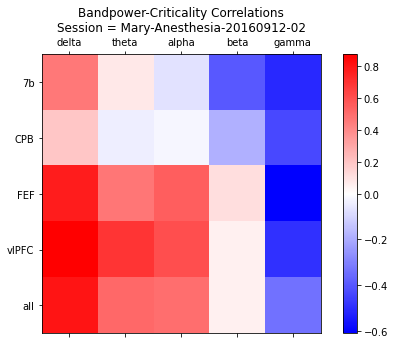

In [23]:
# define your scale, with white at zero
plt.figure(figsize=(8, 5))
vmin = correlation_mat.min()
vmax = correlation_mat.max()
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

plt.matshow(correlation_mat, cmap='bwr', norm=norm, fignum=1)
plt.yticks(np.arange(5), areas)
plt.xticks(np.arange(5), band_names)
plt.colorbar()
plt.title(f"Bandpower-Criticality Correlations\nSession = {session}")
plt.show()

## Correlations In Wakeful Baseline vs Anesthesia

In [24]:
drug_start = int(session_info['drugStart'][0]/dt)
eyes_close = session_info['eyesClose'][1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']
eyes_close = int(eyes_close/dt)
drug_end = int(session_info['drugEnd'][1]/dt)

In [25]:
correlations = {}
p_values = {}
iterator = tqdm(total=len(VAR_results)*len(bands))
for area in VAR_results.keys():
    correlations[area] = {}
    p_values[area] = {}
    for band in bands.keys():
        correlations[area][band] = {}
        p_values[area][band] = {}
        correlations[area][band]['wakeful'], p_values[area][band]['wakeful'] = scipy.stats.pearsonr(band_power_dict[area][band][:drug_start], criticality_dict[area][:drug_start])
        correlations[area][band]['anesthesia'], p_values[area][band]['anesthesia'] = scipy.stats.pearsonr(band_power_dict[area][band][eyes_close:drug_end], criticality_dict[area][eyes_close:drug_end])
        iterator.update()
iterator.close()

  0%|          | 0/25 [00:00<?, ?it/s]

In [26]:
areas = list(VAR_results.keys())
band_names = list(bands.keys())

correlation_mat_wakeful = np.zeros((len(areas), len(band_names)))
correlation_mat_anesthesia = np.zeros((len(areas), len(band_names)))

for i, area in enumerate(areas):
    for j, band_name in enumerate(band_names):
        correlation_mat_wakeful[i][j] = correlations[area][band_name]['wakeful']
        correlation_mat_anesthesia[i][j] = correlations[area][band_name]['anesthesia']

NameError: name 'make_axes_locatable' is not defined

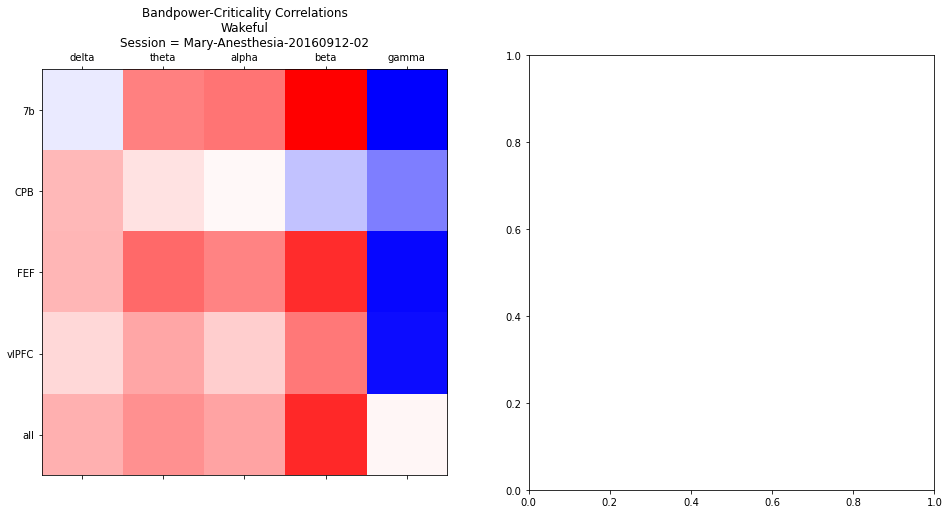

In [27]:
# define your scale, with white at zero
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

ax = axs[0]
vmin = correlation_mat_wakeful.min()
vmax = correlation_mat_wakeful.max()
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

im1 = ax.matshow(correlation_mat_wakeful, cmap='bwr', norm=norm)
ax.set_yticks(np.arange(5))
ax.set_yticklabels(areas)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(band_names)
ax.set_title(f"Bandpower-Criticality Correlations\nWakeful\nSession = {session}")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax = axs[1]
vmin = correlation_mat_anesthesia.min()
vmax = correlation_mat_anesthesia.max()
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

im1 = ax.matshow(correlation_mat_anesthesia, cmap='bwr', norm=norm)
ax.set_yticks(np.arange(5))
ax.set_yticklabels(areas)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(band_names)
ax.set_title(f"Bandpower-Criticality Correlations\nAnesthesia\nSession = {session}")


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

## Moving Correlation from Wakefulness to Anesthesia

In [11]:
drug_start, eyes_close

NameError: name 'drug_start' is not defined

# Plot Individual Areas and Spectral Power

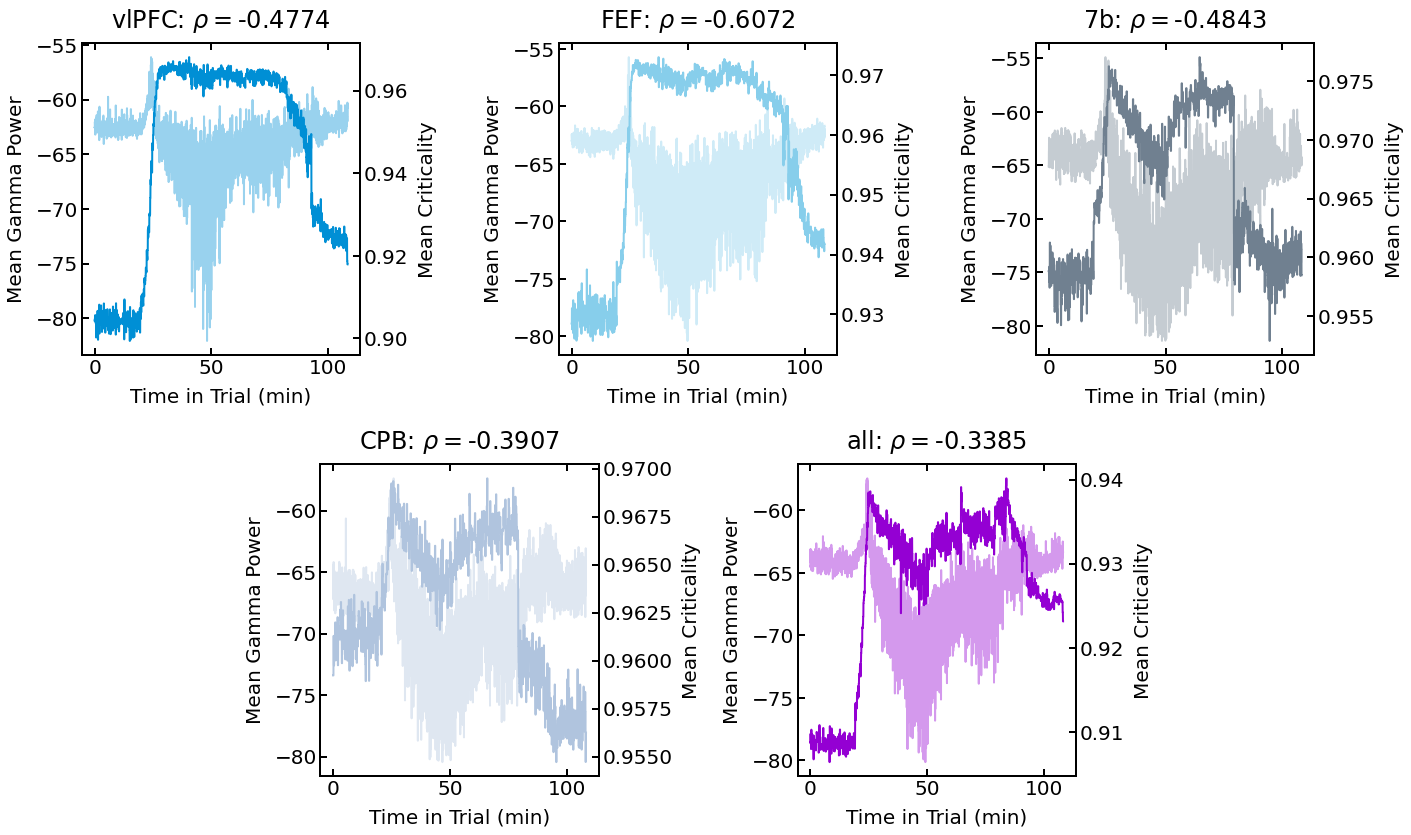

In [53]:
plt.style.use('../../sci_style.py')
# area = 'vlPFC'
band = 'gamma'
# band = 'delta'

plt.figure(figsize=(20, 12))

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

axs = [ax1, ax2, ax3, ax4, ax5]

for ax, area in zip(axs, area_colors.keys()):

    ## PLOT

    lns1 = ax.plot(np.arange(num_pts)/(1000*60), band_power_dict[area][band], label=f'{area} {band} power', c=area_colors[area], alpha=0.4)
    ax2 = ax.twinx()
    lns2 = ax2.plot(np.arange(num_pts)/(1000*60), criticality_dict[area], c=area_colors[area], label=f'{area} mean criticality')
#     lns = lns1+lns2
#     labs = [l.get_label() for l in lns]
#     ax.legend(lns, labs, loc=0)
    ax.set_xlabel('Time in Trial (min)')
    ax.set_ylabel(f'Mean {band.capitalize()} Power')
    ax2.set_ylabel('Mean Criticality')
    ax.set_title(f"{area}: " + r"$\rho = $" + f"{correlations[area][band]:.4f}")
plt.tight_layout()
plt.show()

# Compute Spectrogram Example

In [75]:
unit_index = 0
start_time = 0 # s
duration = 6504 # s

start_step = int(start_time/dt)
length = int(duration/dt)

signal_in = lfp[start_step:start_step + length, unit_index]
# signal_in = lfp[:6504000, 0]

In [90]:
# spectrogram_kwargs = dict(
#     method='multitaper',
#     spec_type='power',
#     time_width=2,
#     freq_width=1,
#     spacing=0.25,
#     freq_range=[0, 80],
# )

spectrogram_kwargs = dict(
    method='multitaper',
    spec_type='power',
    time_width=2,
    freq_width=0.5,
    spacing=2,
    freq_range=[0, 80],
)

# k = spectrogram_kwargs['time_width']*fs
# r = (spectrogram_kwargs['time_width'] - spectrogram_kwargs['spacing'])*fs
# num_timepts = int((length - r)/(k - r))

spec, freq, timepts = spectra.spectrogram(signal_in, 1/dt, **spectrogram_kwargs)

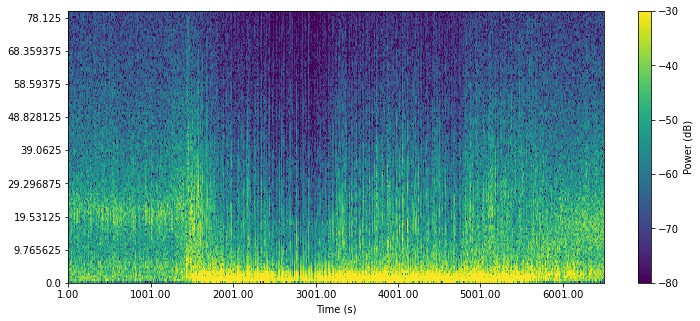

In [91]:
plt.figure(figsize=(12, 5))
plt.pcolormesh(10*np.log10(spec))
xtick_locs = plt.xticks()[0][:-1]
plt.xticks(xtick_locs,[f'{timepts[int(val)] + start_time:.2f}' for val in xtick_locs])
plt.xlabel('Time (s)')
ytick_locs = plt.yticks()[0][:-1]
plt.yticks(ytick_locs,[freq[int(val)]for val in ytick_locs])
plt.colorbar(label='Power (dB)')
plt.clim([-80, -30])
plt.show()

# Phase Plots

In [8]:
area = 'vlPFC'

In [36]:
anesthesia_start_ind = np.argmax(VAR_results[area].start_time > session_info['drugStart'][0])
eyes_close = session_info['eyesClose'][1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']
eyes_close_ind = np.argmax(VAR_results[area].start_time > eyes_close)
anesthesia_end_ind = np.argmax(VAR_results[area].start_time > session_info['drugEnd'][1])

In [23]:
freqs = VAR_results[area].eigs.apply(lambda x: np.angle(x)/(2*np.pi*dt))

In [42]:
wakeful_pairs = []
for i in range(0, anesthesia_start_ind):
    wakeful_pairs.extend([(ci, f) for f, ci in zip(freqs.iloc[i], VAR_results[area].criticality_inds.iloc[i]) if f >= 0])
    
anesthesia_pairs = []
for i in range(eyes_close_ind, anesthesia_end_ind):
    anesthesia_pairs.extend([(ci, f) for f, ci in zip(freqs.iloc[i], VAR_results[area].criticality_inds.iloc[i]) if f >= 0])

In [43]:
wakeful_pairs = np.array(wakeful_pairs)
anesthesia_pairs = np.array(anesthesia_pairs)

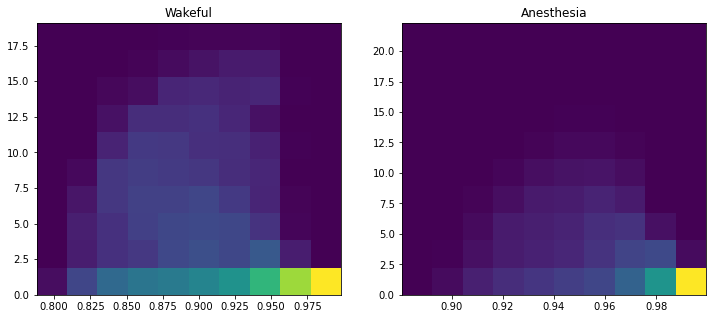

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

ax = axs[0]
ax.hist2d(wakeful_pairs[:, 0], wakeful_pairs[:, 1])
ax.set_title("Wakeful")

ax = axs[1]
ax.hist2d(anesthesia_pairs[:, 0], anesthesia_pairs[:, 1])
ax.set_title("Anesthesia")

plt.show()